In [21]:
import pandas as pd
import numpy as np

# Load dataset
file_path = '/Users/amnasohail/Desktop/Stage 4/final_merged_data.csv'
data = pd.read_csv(file_path)

# Make columns for cases and deaths in the date range
case_columns = [col for col in data.columns if '_cases' in col and '2020-06-01' <= col.split('_')[0] <= '2021-01-03']
death_columns = [col for col in data.columns if '_deaths' in col and '2020-06-01' <= col.split('_')[0] <= '2021-01-03']

# Filter data for Arizona
data_az = data[data['State'] == 'AZ'].copy()

# Top 5 counties with the highest cases
data_az['total_cases'] = data_az[case_columns].sum(axis=1)
top_counties = data_az.groupby('County Name')['total_cases'].sum().nlargest(5).index.tolist()
data_az_top = data_az[data_az['County Name'].isin(top_counties)]

# Melt to reshape data
cases_data = data_az_top.melt(id_vars=['countyFIPS', 'County Name', 'State', 'population'], 
                              value_vars=case_columns, 
                              var_name='date', 
                              value_name='cases')
deaths_data = data_az_top.melt(id_vars=['countyFIPS', 'County Name', 'State', 'population'], 
                               value_vars=death_columns, 
                               var_name='date', 
                               value_name='deaths')

# Clean up 'date' column
cases_data['date'] = cases_data['date'].str.replace('_cases', '', regex=False)
deaths_data['date'] = deaths_data['date'].str.replace('_deaths', '', regex=False)

# Merge cases and deaths data 
data_long = pd.merge(cases_data, deaths_data, on=['countyFIPS', 'County Name', 'State', 'population', 'date'])

# Making sure 'date' is in datetime format and filter for date range
data_long['date'] = pd.to_datetime(data_long['date'], errors='coerce')
data_long = data_long.dropna(subset=['date'])

# Calculate 'day_number' since the start date
start_date = pd.to_datetime('2020-06-01')
data_long['day_number'] = (data_long['date'] - start_date).dt.days

# Display a sample 
print(data_long[['County Name', 'date', 'day_number', 'cases', 'deaths']].head())


        County Name       date  day_number  cases  deaths
0  Maricopa County  2020-06-01           0   9937     433
1    Navajo County  2020-06-01           0   1873      64
2      Pima County  2020-06-01           0   2382     185
3     Pinal County  2020-06-01           0    865      39
4      Yuma County  2020-06-01           0   1131      15


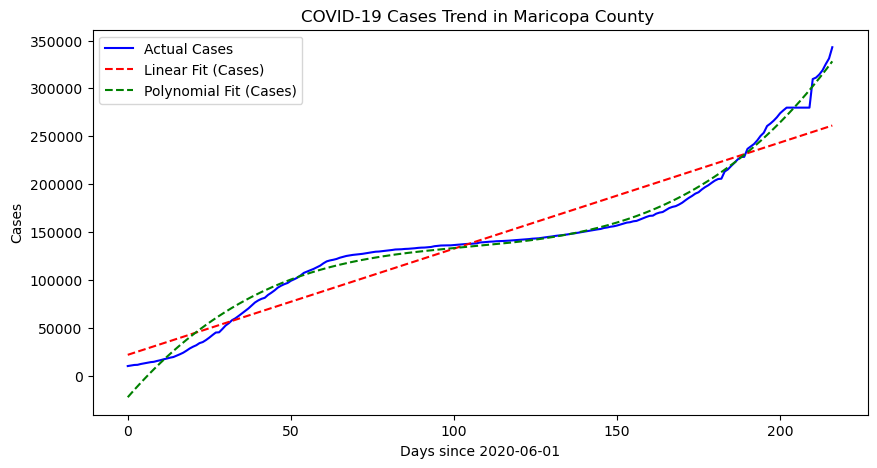

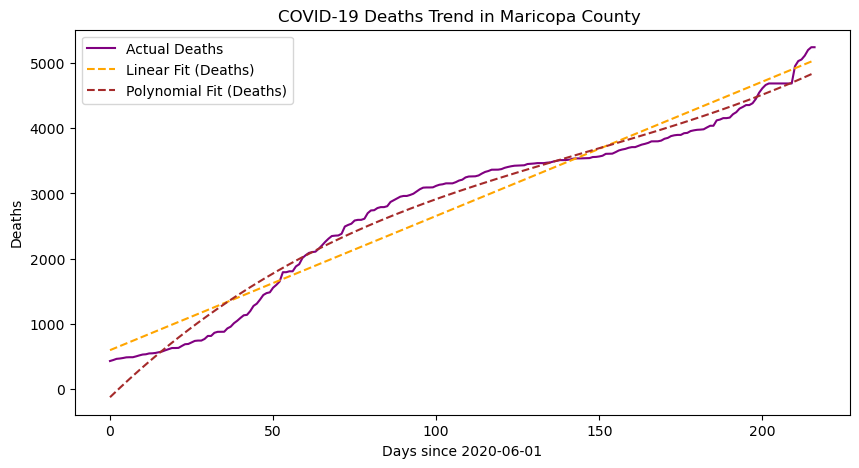

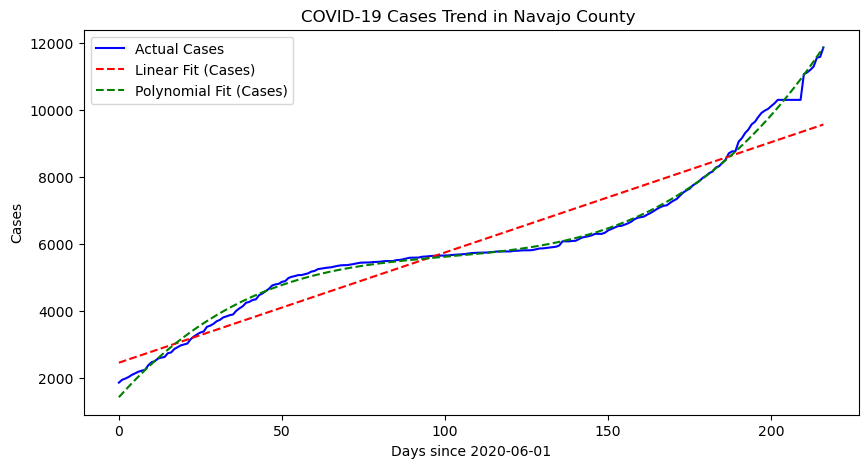

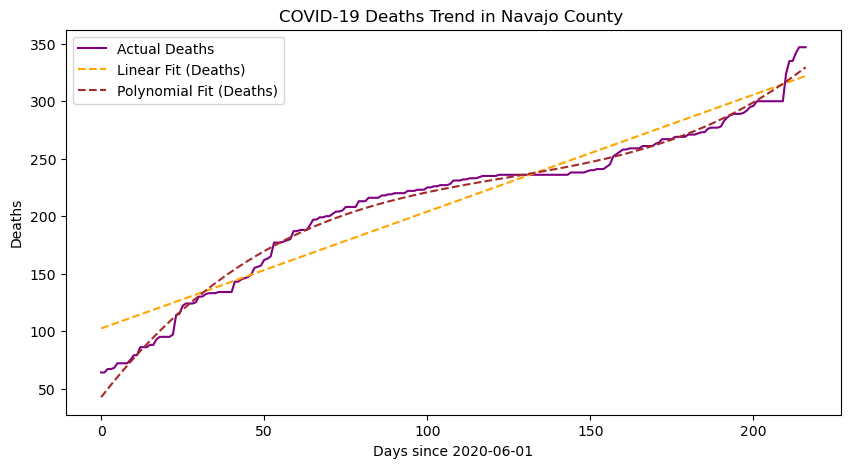

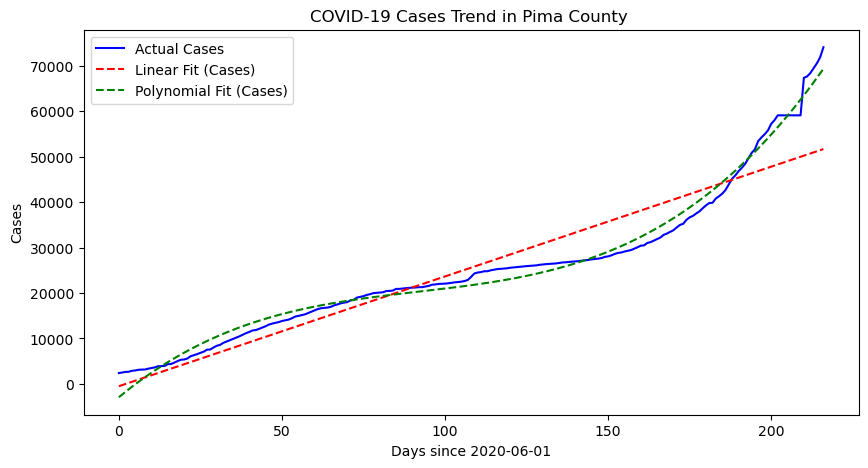

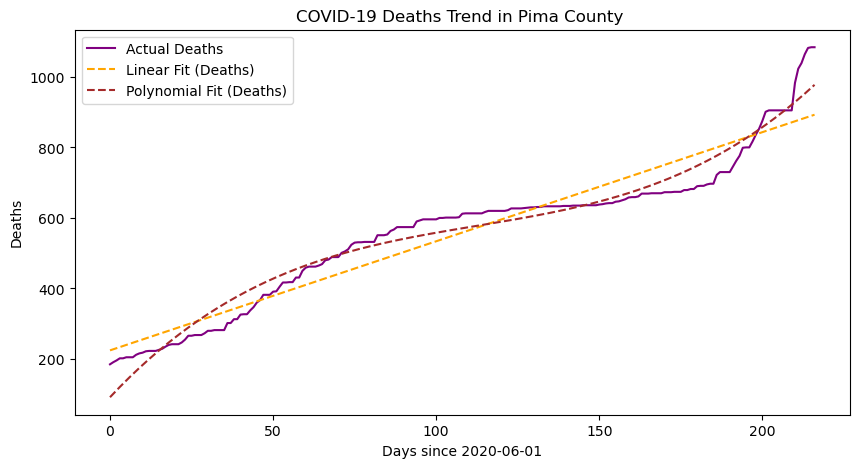

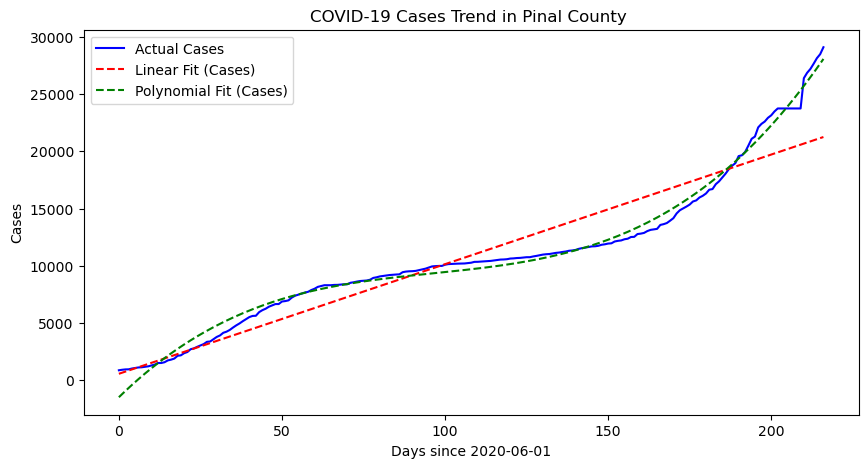

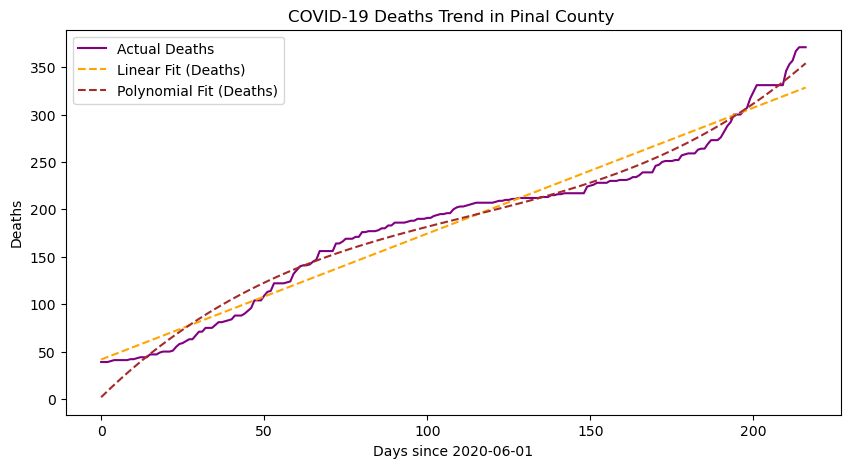

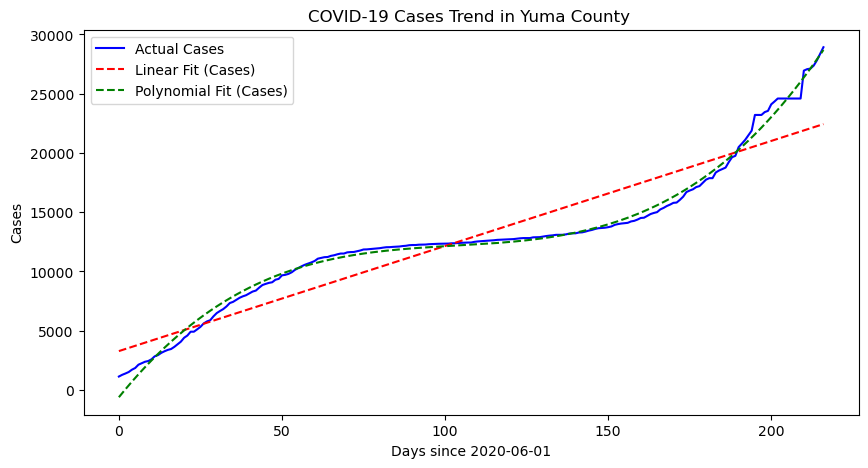

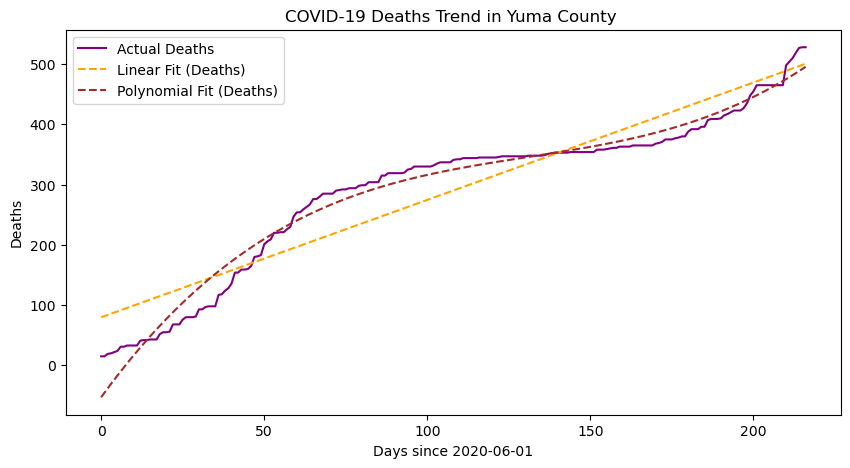

              County                Model          RMSE
0   Maricopa County        Linear (Cases)  23545.820178
1   Maricopa County    Polynomial (Cases)   7739.047496
2   Maricopa County       Linear (Deaths)    306.210400
3   Maricopa County   Polynomial (Deaths)    200.871140
4     Navajo County        Linear (Cases)    723.684281
5     Navajo County    Polynomial (Cases)    144.753883
6     Navajo County       Linear (Deaths)     18.987025
7     Navajo County   Polynomial (Deaths)      6.980143
8       Pima County        Linear (Cases)   5542.616799
9       Pima County    Polynomial (Cases)   1868.638673
10      Pima County       Linear (Deaths)     59.678692
11      Pima County   Polynomial (Deaths)     40.697666
12     Pinal County        Linear (Cases)   2132.805626
13     Pinal County    Polynomial (Cases)    638.502562
14     Pinal County       Linear (Deaths)     17.742388
15     Pinal County   Polynomial (Deaths)     11.961455
16      Yuma County        Linear (Cases)   2101

In [22]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# an empty list to store RMSE results
rmse_results = []

# each top county models
for county in data_long['County Name'].unique():
    county_data = data_long[data_long['County Name'] == county]
    
    # Prepare data for regression
    X = county_data[['day_number']].values  # Independent variable
    y_cases = county_data['cases'].values  # Dependent variable for cases
    y_deaths = county_data['deaths'].values  # Dependent variable for deaths
    
    # Linear Regression for cases
    linear_model_cases = LinearRegression()
    linear_model_cases.fit(X, y_cases)
    y_pred_cases_linear = linear_model_cases.predict(X)
    rmse_cases_linear = np.sqrt(mean_squared_error(y_cases, y_pred_cases_linear))
    
    # Polynomial Regression for cases
    poly_features = PolynomialFeatures(degree=3)
    X_poly = poly_features.fit_transform(X)
    poly_model_cases = LinearRegression()
    poly_model_cases.fit(X_poly, y_cases)
    y_pred_cases_poly = poly_model_cases.predict(X_poly)
    rmse_cases_poly = np.sqrt(mean_squared_error(y_cases, y_pred_cases_poly))
    
    # RMSE 
    rmse_results.append({
        'County': county,
        'Model': 'Linear (Cases)',
        'RMSE': rmse_cases_linear
    })
    rmse_results.append({
        'County': county,
        'Model': 'Polynomial (Cases)',
        'RMSE': rmse_cases_poly
    })
    
 
    # Linear Regression for deaths
    linear_model_deaths = LinearRegression()
    linear_model_deaths.fit(X, y_deaths)
    y_pred_deaths_linear = linear_model_deaths.predict(X)
    rmse_deaths_linear = np.sqrt(mean_squared_error(y_deaths, y_pred_deaths_linear))
    
    # Polynomial Regression for deaths
    poly_model_deaths = LinearRegression()
    poly_model_deaths.fit(X_poly, y_deaths)
    y_pred_deaths_poly = poly_model_deaths.predict(X_poly)
    rmse_deaths_poly = np.sqrt(mean_squared_error(y_deaths, y_pred_deaths_poly))
    
    # RMSE
    rmse_results.append({
        'County': county,
        'Model': 'Linear (Deaths)',
        'RMSE': rmse_deaths_linear
    })
    rmse_results.append({
        'County': county,
        'Model': 'Polynomial (Deaths)',
        'RMSE': rmse_deaths_poly
    })
    
    # Plotting for Cases
    plt.figure(figsize=(10, 5))
    plt.plot(county_data['day_number'], y_cases, label='Actual Cases', color='blue')
    plt.plot(county_data['day_number'], y_pred_cases_linear, label='Linear Fit (Cases)', linestyle='--', color='red')
    plt.plot(county_data['day_number'], y_pred_cases_poly, label='Polynomial Fit (Cases)', linestyle='--', color='green')
    plt.xlabel('Days since 2020-06-01')
    plt.ylabel('Cases')
    plt.title(f'COVID-19 Cases Trend in {county}')
    plt.legend()
    plt.show()
    
    # Plotting for Deaths
    plt.figure(figsize=(10, 5))
    plt.plot(county_data['day_number'], y_deaths, label='Actual Deaths', color='purple')
    plt.plot(county_data['day_number'], y_pred_deaths_linear, label='Linear Fit (Deaths)', linestyle='--', color='orange')
    plt.plot(county_data['day_number'], y_pred_deaths_poly, label='Polynomial Fit (Deaths)', linestyle='--', color='brown')
    plt.xlabel('Days since 2020-06-01')
    plt.ylabel('Deaths')
    plt.title(f'COVID-19 Deaths Trend in {county}')
    plt.legend()
    plt.show()

# Display RMSE results
rmse_df = pd.DataFrame(rmse_results)
print(rmse_df)


In [23]:
from scipy.stats import linregress

# Store descriptions and risk assessment for each county
risk_assessment = []

for county in data_long['County Name'].unique():
    county_data = data_long[data_long['County Name'] == county]
    
    # Linear regression for the trend in cases 
    slope_cases, intercept, r_value, p_value, std_err = linregress(county_data['day_number'], county_data['cases'])
    slope_deaths, _, _, _, _ = linregress(county_data['day_number'], county_data['deaths'])
    
    # Determine trend type based on slope of the linear regression
    trend_description_cases = "increasing" if slope_cases > 0 else "decreasing" if slope_cases < 0 else "stable"
    trend_description_deaths = "increasing" if slope_deaths > 0 else "decreasing" if slope_deaths < 0 else "stable"
    
    # Risk assessment based on slope and average number of cases/deaths
    avg_cases = county_data['cases'].mean()
    avg_deaths = county_data['deaths'].mean()
    high_cases_threshold = 1000  
    high_deaths_threshold = 50  
    
    risk_level = "High" if slope_cases > 0 and avg_cases > high_cases_threshold else "Moderate" if slope_cases > 0 else "Low"
    
    # Storeing the analysis in a dictionary
    risk_assessment.append({
        'County': county,
        'Avg Cases': avg_cases,
        'Avg Deaths': avg_deaths,
        'Cases Trend': trend_description_cases,
        'Deaths Trend': trend_description_deaths,
        'Risk Level': risk_level
    })

risk_df = pd.DataFrame(risk_assessment)
print(risk_df)


             County      Avg Cases   Avg Deaths Cases Trend Deaths Trend  \
0  Maricopa County   141428.732719  2819.898618  increasing   increasing   
1    Navajo County     6016.751152   212.124424  increasing   increasing   
2      Pima County    25588.221198   558.580645  increasing   increasing   
3     Pinal County    10902.437788   185.055300  increasing   increasing   
4      Yuma County    12855.534562   290.221198  increasing   increasing   

  Risk Level  
0       High  
1       High  
2       High  
3       High  
4       High  


In this analysis, I looked at COVID-19 trends and assessed risk levels for the top 5 counties in Arizona. For each county, I used linear regression to check if the cases and deaths were increasing, decreasing, or stable over time. If the slope of the regression line was positive, it meant cases or deaths were rising; if it was negative, they were decreasing. I also calculated the average number of cases and deaths per county to understand the overall severity. Counties with a rising trend in cases and an average above 1,000 were labeled as "High" risk, while those with lower averages or stable trends would have been considered "Moderate" or "Low" risk. In this case, all five counties (Maricopa, Navajo, Pima, Pinal, and Yuma) showed increasing trends and high average cases, so they were all classified as high-risk counties.

In [34]:
import pandas as pd
from scipy.stats import ttest_ind

# Load COVID-19 data and employment data
covid_data_path = '/Users/amnasohail/Desktop/Stage 4/final_merged_data.csv'
employment_data_path = '/Users/amnasohail/Desktop/405/Stage 3/allhlcn20.xlsx'

covid_data = pd.read_csv(covid_data_path)
employment_data = pd.read_excel(employment_data_path)

# Filter COVID-19 data for Arizona and calculate total cases
covid_data_az = covid_data[covid_data['State'] == 'AZ'].copy()
date_columns = [col for col in covid_data_az.columns if '_cases' in col]
covid_data_az.loc[:, 'total_cases'] = covid_data_az[date_columns].sum(axis=1)

# Filter employment data for Arizona counties and drop NaNs
employment_data_az = employment_data[(employment_data['St Name'] == 'Arizona') & 
                                     (employment_data['Area Type'] == 'County')]
employment_data_az = employment_data_az[['Area', 'Annual Average Employment']].dropna()
employment_data_az.columns = ['County Name', 'Average Employment']

# Calculate the overall average employment level for Arizona counties
average_employment_az = employment_data_az['Average Employment'].mean()

# Merge COVID-19 data with employment data on County Name
merged_data = pd.merge(covid_data_az, employment_data_az, on='County Name')

# Categorize counties based on above or below average employment level
merged_data['employment_level'] = merged_data['Average Employment'].apply(
    lambda x: 'above average employment' if x > average_employment_az else 'below average employment'
)

# Calculate COVID-19 cases per 100,000 people for each county
merged_data['cases_per_100k'] = (merged_data['total_cases'] / merged_data['population']) * 100000

# Remove any rows with NaN values
merged_data = merged_data.dropna(subset=['cases_per_100k'])

# Split data into groups for t-test
above_avg_cases_per_capita = merged_data[merged_data['employment_level'] == 'above average employment']['cases_per_100k']
below_avg_cases_per_capita = merged_data[merged_data['employment_level'] == 'below average employment']['cases_per_100k']

# Check if both groups have enough data
if len(above_avg_cases_per_capita) > 1 and len(below_avg_cases_per_capita) > 1:
    # Do two-sample t-test
    t_stat, p_value = ttest_ind(above_avg_cases_per_capita, below_avg_cases_per_capita, equal_var=False)
    
    # Display t-test results
    print("Two-sample t-test results comparing cases per 100k between employment levels in Arizona counties:")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")
else:
    print("Not enough data in one or both groups to perform a valid t-test.")


Not enough data in one or both groups to perform a valid t-test.


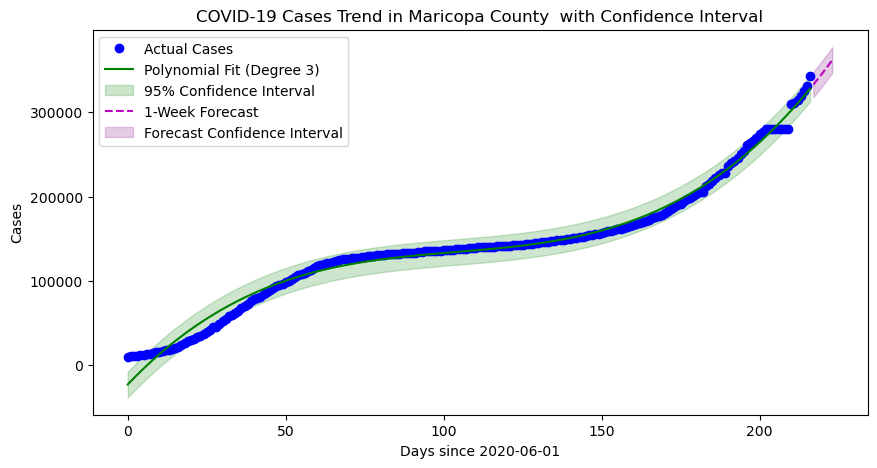

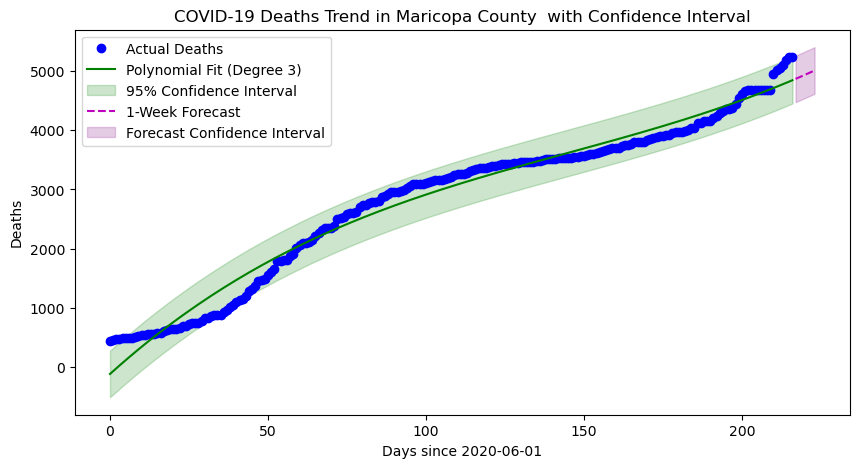

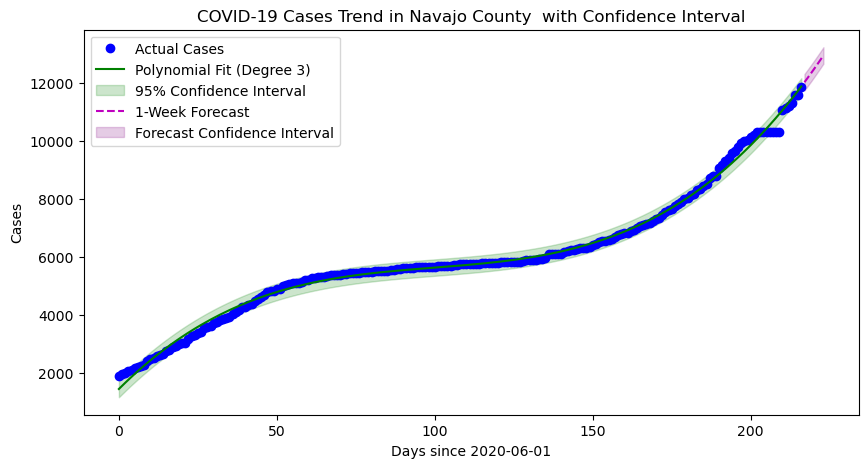

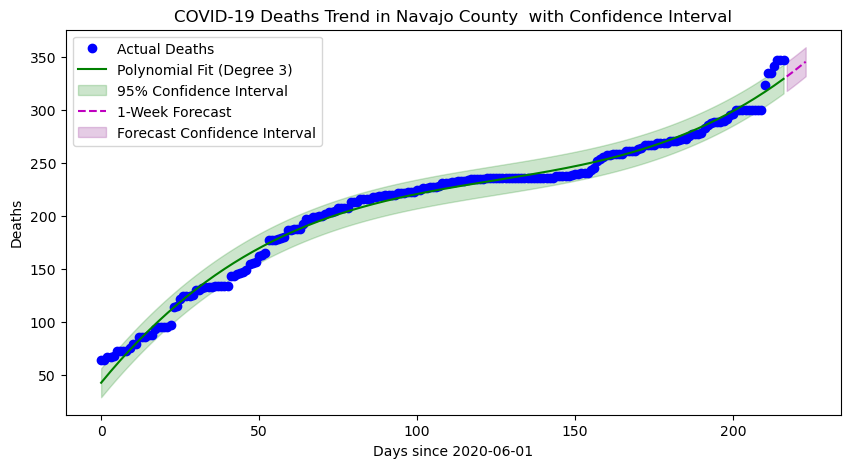

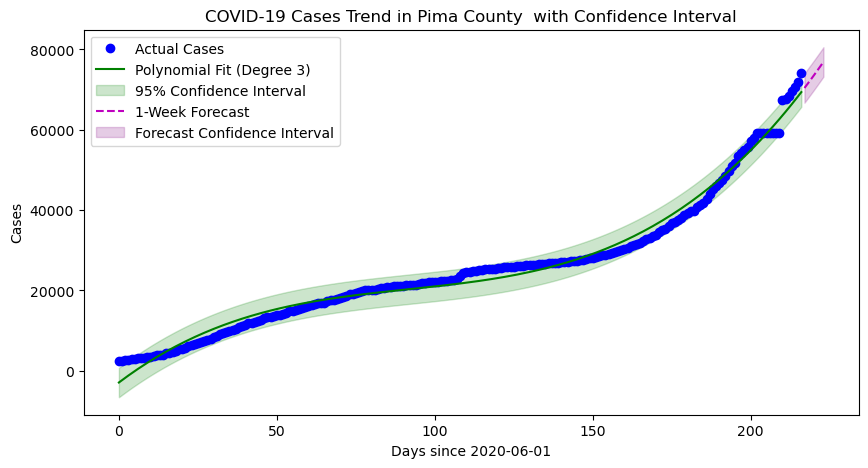

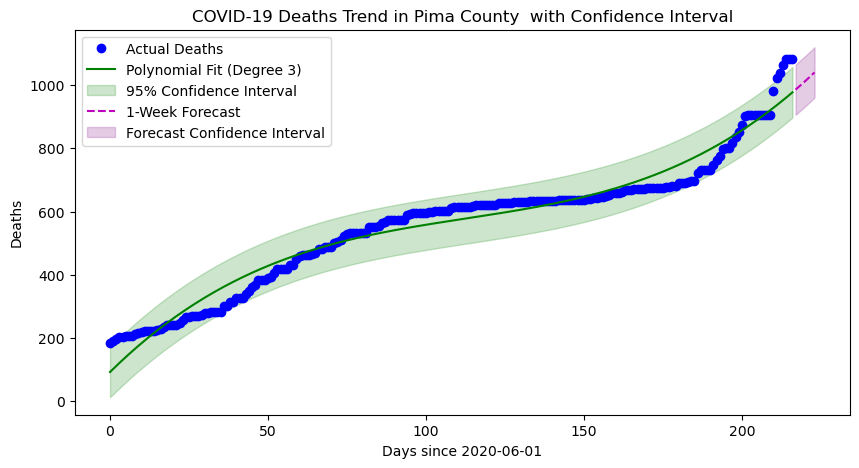

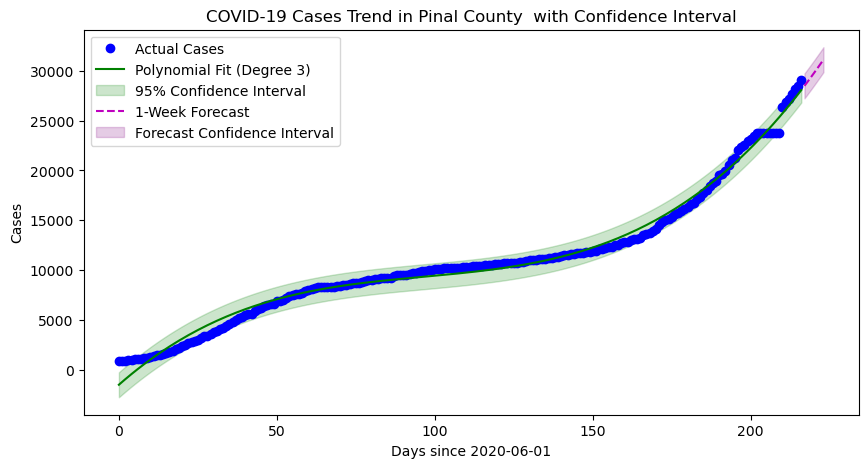

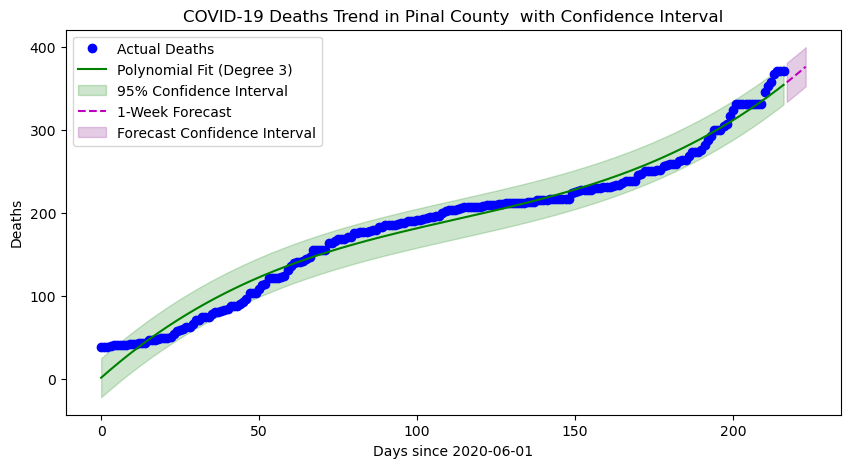

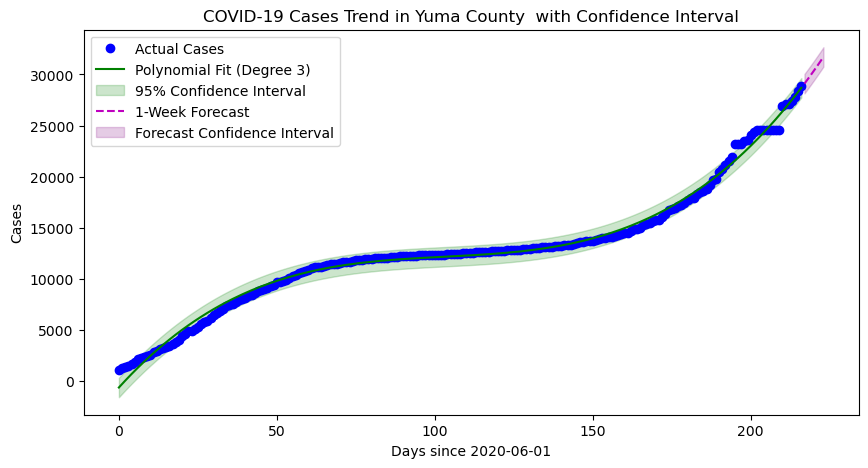

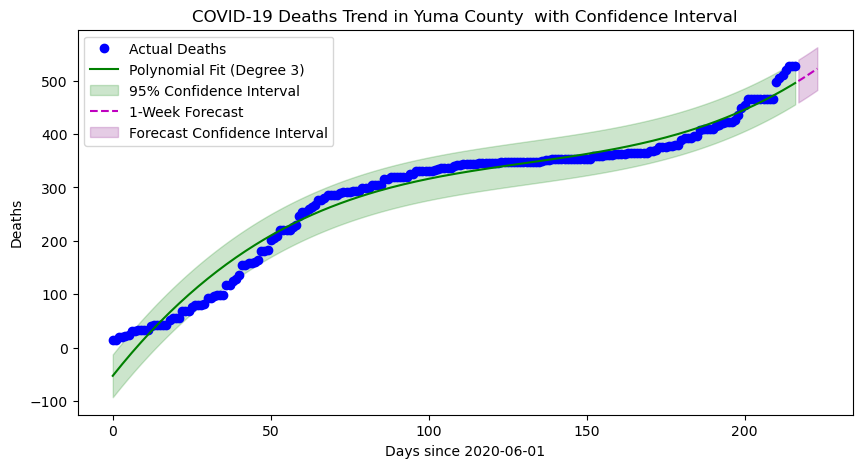

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

for county in data_long['County Name'].unique():
    county_data = data_long[data_long['County Name'] == county]
    
    X = county_data[['day_number']].values  
    y_cases = county_data['cases'].values  
    y_deaths = county_data['deaths'].values  
    
    # Polynomial Regression for cases
    poly_features = PolynomialFeatures(degree=3)
    X_poly = poly_features.fit_transform(X)
    poly_model_cases = LinearRegression()
    poly_model_cases.fit(X_poly, y_cases)
    y_pred_cases_poly = poly_model_cases.predict(X_poly)
    rmse_cases_poly = np.sqrt(mean_squared_error(y_cases, y_pred_cases_poly))
    
    # Polynomial Regression  for deaths
    poly_model_deaths = LinearRegression()
    poly_model_deaths.fit(X_poly, y_deaths)
    y_pred_deaths_poly = poly_model_deaths.predict(X_poly)
    rmse_deaths_poly = np.sqrt(mean_squared_error(y_deaths, y_pred_deaths_poly))

    # Forecasting for the next 7 days
    last_day = X[-1][0]  
    X_future = np.arange(last_day + 1, last_day + 8).reshape(-1, 1)
    X_future_poly = poly_features.transform(X_future)
    y_cases_forecast = poly_model_cases.predict(X_future_poly)
    y_deaths_forecast = poly_model_deaths.predict(X_future_poly)

    # Calculate 95% confidence intervals
    cases_error = np.sqrt(mean_squared_error(y_cases, y_pred_cases_poly))
    deaths_error = np.sqrt(mean_squared_error(y_deaths, y_pred_deaths_poly))
    y_cases_upper = y_pred_cases_poly + 1.96 * cases_error
    y_cases_lower = y_pred_cases_poly - 1.96 * cases_error
    y_cases_forecast_upper = y_cases_forecast + 1.96 * cases_error
    y_cases_forecast_lower = y_cases_forecast - 1.96 * cases_error
    y_deaths_upper = y_pred_deaths_poly + 1.96 * deaths_error
    y_deaths_lower = y_pred_deaths_poly - 1.96 * deaths_error
    y_deaths_forecast_upper = y_deaths_forecast + 1.96 * deaths_error
    y_deaths_forecast_lower = y_deaths_forecast - 1.96 * deaths_error

    # Plotting for Cases
    plt.figure(figsize=(10, 5))
    plt.plot(county_data['day_number'].to_numpy(), y_cases, 'bo', label='Actual Cases')
    plt.plot(county_data['day_number'].to_numpy(), y_pred_cases_poly, 'g-', label='Polynomial Fit (Degree 3)')
    plt.fill_between(county_data['day_number'].to_numpy(), y_cases_lower, y_cases_upper, color='green', alpha=0.2, label="95% Confidence Interval")
    plt.plot(X_future.flatten(), y_cases_forecast, 'm--', label='1-Week Forecast')
    plt.fill_between(X_future.flatten(), y_cases_forecast_lower, y_cases_forecast_upper, color='purple', alpha=0.2, label="Forecast Confidence Interval")
    plt.xlabel('Days since 2020-06-01')
    plt.ylabel('Cases')
    plt.title(f'COVID-19 Cases Trend in {county} with Confidence Interval')
    plt.legend()
    plt.show()

    # Plotting for Deaths
    plt.figure(figsize=(10, 5))
    plt.plot(county_data['day_number'].to_numpy(), y_deaths, 'bo', label='Actual Deaths')
    plt.plot(county_data['day_number'].to_numpy(), y_pred_deaths_poly, 'g-', label='Polynomial Fit (Degree 3)')
    plt.fill_between(county_data['day_number'].to_numpy(), y_deaths_lower, y_deaths_upper, color='green', alpha=0.2, label="95% Confidence Interval")
    plt.plot(X_future.flatten(), y_deaths_forecast, 'm--', label='1-Week Forecast')
    plt.fill_between(X_future.flatten(), y_deaths_forecast_lower, y_deaths_forecast_upper, color='purple', alpha=0.2, label="Forecast Confidence Interval")
    plt.xlabel('Days since 2020-06-01')
    plt.ylabel('Deaths')
    plt.title(f'COVID-19 Deaths Trend in {county} with Confidence Interval')
    plt.legend()
    plt.show()

